In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [22]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self,bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
    
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets_ = [X[y==yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi) for Xi in training_sets_]
        print(self.models_)
        self.logpriors_ = [np.log(Xi.shape[0]/X.shape[0]) for Xi in training_sets_]

        return self

    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1,keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X),1)]

    

In [23]:
digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)



[KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity()]
[KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity()]
[KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity()]
[KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity()]
[KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity(), KernelDensity()]
[KernelDensity(bandwidth=1.0476157527896648), KernelDensity(bandwidth=1.0476157527896648), KernelDensity(bandwidth=1.0476157527896648), KernelDen

GridSearchCV(estimator=KDEClassifier(),
             param_grid={'bandwidth': array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,
         1.20450354,   1.26185688,   1.32194115,   1.38488637,
         1.45082878,   1.51991108,   1.59228279,   1.66810054,
         1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,
         2.10490414,   2.20513074,   2.3101297 ,   2.42012826,
         2.53536449,   2.65608778,   2.7825594 ,   2.91505306,
         3.05385551,   3.19926714,   3.3516026...
        23.64489413,  24.77076356,  25.95024211,  27.18588243,
        28.48035868,  29.8364724 ,  31.2571585 ,  32.74549163,
        34.30469286,  35.93813664,  37.64935807,  39.44206059,
        41.320124  ,  43.28761281,  45.34878508,  47.50810162,
        49.77023564,  52.14008288,  54.62277218,  57.22367659,
        59.94842503,  62.80291442,  65.79332247,  68.92612104,
        72.20809018,  75.64633276,  79.24828984,  83.02175681,
        86.97490026,  91.11627561,  95.45484567, 100.        ])})

In [24]:
#print(grid.cv_results_["mean_test_score"])
scores = [val for val in grid.cv_results_["mean_test_score"]]

{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


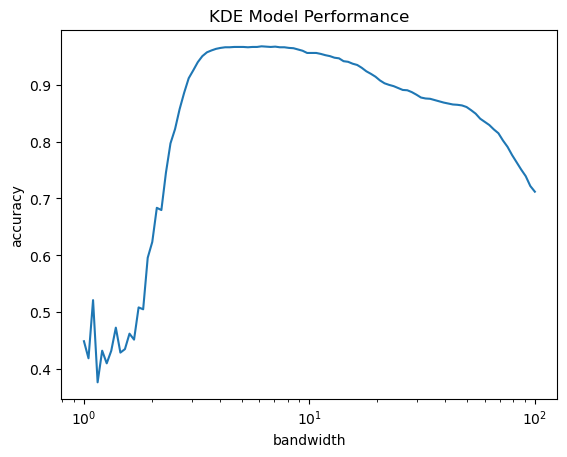

In [25]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

In [ ]:
class RKDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self,bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def robust_kde(data, x, kernel='gaussian', num_iterations=10, alpha=0.5):
        """Robust Kernel density estimation using IRLS algorithm."""
        n = len(data)
        weights = np.ones(n)
        robust_density = np.zeros_like(x)

        if num_iterations == 0:
            return kde(data, x, bandwidth=1.0, kernel=kernel)

        density = kde(data, x, bandwidth=1.0, kernel=kernel)

        # Calculate the residuals
        residuals = np.abs(data[:, np.newaxis] - x)

        # Update the weights using the robust M-estimator
        weights = np.power(np.maximum(1 - np.power(residuals / alpha, 2), 0), 2)

        # Calculate the weighted sum of densities
        weighted_density = np.sum(density * weights, axis=0)

        # Normalize the density estimate
        robust_density = weighted_density / np.sum(weights, axis=0)

        return robust_kde(data, x, kernel=kernel, num_iterations=num_iterations-1, alpha=alpha)

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets_ = [X[y==yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi) for Xi in training_sets_]
        print(self.models_)
        self.logpriors_ = [np.log(Xi.shape[0]/X.shape[0]) for Xi in training_sets_]

        return self

    def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1,keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X),1)]
